In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pygame

import torch
import torch.nn as nn
import torch.nn.functional as F

from math import *
from IPython import display

import time
import copy

DEVICE = "cuda"

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


# Pathfinder stuff

In [12]:
#  0
#3   1
#  2

CHANNELS = 3

class Pathfinder(nn.Module):
    def __init__(self):
        pass
    
    def get_potential(self, costs, goals, cost_to_point = None, parent_cell = None, max_steps = 10):
        # costs: RES x RES
        # goals: N x 3
        
        if cost_to_point is None:
            cost_to_point = torch.zeros(costs.shape[0], costs.shape[1], CHANNELS).to(DEVICE)+1e9
            parent_cell = torch.zeros(costs.shape[0], costs.shape[1], CHANNELS).long().to(DEVICE) - 1
        
        for i in range(goals.shape[0]):
                cost_to_point[goals[i,1], goals[i,0], goals[i,2]] = 0
        
        changed = 1
        steps = 0
        while changed>0 and steps<max_steps:
            changed = 0
            steps += 1
            
            roll_xp = torch.cat([cost_to_point[1:,:], cost_to_point[:1,:]], 0) + costs.unsqueeze(2)
            roll_xm = torch.cat([cost_to_point[-1:,:], cost_to_point[:-1,:]], 0) + costs.unsqueeze(2)
            roll_yp = torch.cat([cost_to_point[:,1:], cost_to_point[:,:1]], 1) + costs.unsqueeze(2)
            roll_ym = torch.cat([cost_to_point[:,-1:], cost_to_point[:,:-1]], 1) + costs.unsqueeze(2)
            
            w = torch.lt(roll_xp+0.01, cost_to_point).float()
            cost_to_point = w*roll_xp + (1-w)*cost_to_point
            parent_cell = w*1 + (1-w)*parent_cell
            
            changed += torch.sum(w).detach().cpu().item()
            
            w = torch.lt(roll_xm+0.01, cost_to_point).float()
            cost_to_point = w*roll_xm + (1-w)*cost_to_point
            parent_cell = w*3 + (1-w)*parent_cell

            changed += torch.sum(w).detach().cpu().item()

            w = torch.lt(roll_yp+0.01, cost_to_point).float()
            cost_to_point = w*roll_yp + (1-w)*cost_to_point
            parent_cell = w*2 + (1-w)*parent_cell

            changed += torch.sum(w).detach().cpu().item()
            
            w = torch.lt(roll_ym+0.01, cost_to_point).float()
            cost_to_point = w*roll_ym + (1-w)*cost_to_point
            parent_cell = w*0 + (1-w)*parent_cell

            changed += torch.sum(w).detach().cpu().item()
        
        return cost_to_point, parent_cell
     
    def find_path(self, cost_to_point, parent_cell, start):
        path = []
        current = start
        
        while (parent_cell[current[0], current[1]]>=0):
            path.append(copy.deepcopy(current))
            
            direction = parent_cell[current[0], current[1]]
            if direction == 0:
                current[1] -= 1
            elif direction == 1:
                current[0] += 1
            elif direction == 2:
                current[1] += 1
            else:
                current[0] -= 1
            
            current[0] = (current[0] + cost_to_point.shape[0])%cost_to_point.shape[0]
            current[1] = (current[1] + cost_to_point.shape[1])%cost_to_point.shape[1]
        return path

# Model stuff

In [21]:
from PIL import Image

pathfinder = Pathfinder()



In [42]:
class PathfindingAutomaton(nn.Module):
    def __init__(self, N, RES):
        super().__init__()
        
        self.blur = nn.Conv2d(1, 1, 5, padding=2, padding_mode='circular', bias=None)
        self.blur.weight.data = torch.ones_like(self.blur.weight)/25.0
        
        self.parts = torch.rand(N,2).to(DEVICE)*RES
        self.charges = torch.randint(CHANNELS, size=(N, 1)).to(DEVICE)
        
        self.field = torch.rand(RES, RES, CHANNELS).to(DEVICE)
        self.partbuf = torch.zeros(RES, RES, CHANNELS).to(DEVICE)
        
        self.RES = RES
        
        self.old_cost = 0
        
        self.offsets = torch.FloatTensor(np.array([[-1,-1], [0, -1], [1,-1],
                                                   [-1,0], [0,0], [1,0],
                                                   [-1,1], [0,1], [1,1]])).to(DEVICE)
        #self.offsets = torch.cat([self.offsets[:,1:], self.offsets[:,:1]], 1)
        
        goals = torch.cat( [self.parts.long(), self.charges], 1)
        
        cost, parent = pathfinder.get_potential(torch.exp(-0.1*self.field.sum(2))*10, goals, max_steps=1024)
        self.old_cost = cost
        self.old_parent = parent
            
    def update(self, path_steps = 10, virtual_steps = 100):
        RES = self.RES
        
        goals = torch.cat( [self.parts.long(), self.charges], 1)
        cost_to_point, parent_cell = pathfinder.get_potential(torch.exp(-0.1*self.field.sum(2))*10, goals, 
                                                              cost_to_point = self.old_cost+0.01, 
                                                              parent_cell = self.old_parent,
                                                              max_steps = path_steps)
        self.old_cost = cost_to_point
        
        # Heal towards 1
        self.field = 0.99*self.field
        
        # patches is 1 x 9 x RES*RES
        print(cost_to_point.shape)
        padfield = cost_to_point.permute(2,0,1).view(1,CHANNELS,self.RES,self.RES).contiguous()
        padfield = torch.cat([padfield[:,:,-1:,:], padfield, padfield[:,:,:1,:]], 2)
        padfield = torch.cat([padfield[:,:,:,-1:], padfield, padfield[:,:,:,:1]], 3)
        patches = F.unfold(padfield, 3, padding=0)
        patches = patches.view(CHANNELS, 9, RES*RES).permute(1,0,2).contiguous().view(9,CHANNELS*RES*RES)
        
        virtual_parts = self.parts.clone()
        momenta = torch.zeros_like(virtual_parts)
        
        #self.field = self.field.view(RES*RES*CHANNELS)
        field_addition = torch.zeros_like(self.field).view(RES*RES*CHANNELS)
        charge = (self.charges[:,0]+1)%CHANNELS
        
        self.partbuf *= 0.96
        for i in range(virtual_steps):
            idx = virtual_parts.long()
            
            cidx = charge*RES*RES + idx[:,0] + idx[:, 1]*RES
            cidx = cidx.unsqueeze(0).expand(9, virtual_parts.shape[0])
            
            fidx = (idx[:,0] + idx[:, 1]*RES)*CHANNELS + self.charges[:,0]
            
            local_grads = torch.gather(dim=1, index = cidx, input=patches)
            displacement = torch.sum(self.offsets.unsqueeze(1)*torch.softmax(-local_grads, dim=0).unsqueeze(2),0)
            v_displacement = torch.cat([-displacement[:, 1:], displacement[:, :1]], 1)
            
            dv = displacement
            w = 1+0*torch.sum(dv**2,1)
            
            momenta = 0.99*momenta + 0.01*dv
            
            field_addition.scatter_(dim=0, index = fidx, src=w, reduce='add')
            #momenta /= torch.sqrt(1e-8 + torch.sum(momenta**2, 1).unsqueeze(1))
            
            #best_idx = torch.argmax(-local_grads, 0)
            #displacement = self.offsets[best_idx]
            virtual_parts = torch.fmod(0.5 + virtual_parts + momenta + RES, RES) - 0.5
        
        for i in range(5):
            idx = self.parts.long()
            cidx = charge*RES*RES + idx[:,0] + idx[:, 1]*RES
            cidx = cidx.unsqueeze(0).expand(9, virtual_parts.shape[0])
            
            local_grads = torch.gather(dim=1, index = cidx, input=patches)
            displacement = torch.sum(self.offsets.unsqueeze(1)*torch.softmax(-local_grads, dim=0).unsqueeze(2),0)
            displacement /= torch.sqrt(1e-8 + torch.sum(displacement**2, 1).unsqueeze(1))
            v_displacement = torch.cat([-displacement[:, 1:], displacement[:, :1]], 1)

            self.parts = torch.fmod(0.5 + self.parts - 0.0 * displacement - v_displacement + torch.randn_like(self.parts)*0.25 + RES, RES) - 0.5
            self.partbuf += self.render_parts()
        
        self.field = self.field + torch.clamp(field_addition,0,1).view(RES,RES,CHANNELS)
        
        return patches
    
    def render_parts(self):
        partpos = self.parts.long()
        src = torch.ones_like(self.field.view(-1))
        im = torch.zeros_like(self.field.view(-1))
        
        for dy in range(-1,2):
            for dx in range(-1,2):
                idx = ((partpos[:,0]+dx+self.RES)%self.RES + ((partpos[:,1]+dy+self.RES)%self.RES)*self.RES)*CHANNELS + self.charges[:,0]

                im.scatter_add_(index = idx, dim=0, src=src*exp(-3*(dx*dx+dy*dy)))
        im = im.view(self.RES, self.RES, CHANNELS)
        
        return im

# User interface

In [5]:
pygame.init()
MULT = 2
RES = 256
screen = pygame.display.set_mode((RES*MULT, RES*MULT), 0, 24)

In [43]:
automaton = PathfindingAutomaton(30, RES).to(DEVICE)
#im = 1 - (np.array(Image.open("ref_image.jpg"))/384.0 + 0.25)
#im = im.transpose(1,0)

#cost = torch.FloatTensor(im).contiguous().to(DEVICE)

In [44]:
#!rm /sata/frames/*.png

frame = 0
with torch.no_grad():
    while True:
        patches = automaton.update(path_steps=300, virtual_steps=500)

        for event in pygame.event.get():
            if event.type == pygame.MOUSEBUTTONUP:
                mx = event.pos[0]
                my = event.pos[1]

                # Do stuff

            if event.type == pygame.KEYUP:
                if event.key == 'r':
                    # Do stuff
                    automaton = PathfindingAutomaton(50, 256)

        parts = np.clip(automaton.partbuf.cpu().detach().numpy(), 0, 1)
        afield = 0.25*np.log(1+automaton.field.cpu().detach().numpy())
        meanfield = np.clip(automaton.old_cost.cpu().detach().numpy()/400.0, 0, 1)
        
        #afield = (0.75*meanfield + 0.25*afield)
        im = np.clip((1-parts)*afield*256 + parts*256,0,255).astype(np.uint8)

        #im[:,:,2] = np.clip((1-parts)*meanfield*256,0,255).astype(np.uint8)
        
        
        im = im.repeat(MULT, axis=0)
        im = im.repeat(MULT, axis=1)
        
        s_image = pygame.pixelcopy.make_surface(im)
        
        #im = Image.fromarray(im)
        #im.save("/sata/frames/%.7d.png" % frame)
        frame += 1
        screen.blit(s_image, (0, 0))

        pygame.display.update()   
        time.sleep(0.005)

torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([256, 256, 3])
torch.Size([

KeyboardInterrupt: 

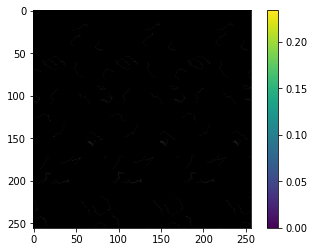

In [68]:
plt.imshow(parts)
plt.colorbar()

In [25]:
cost_to_point = automaton.old_cost[:,:,1]

In [18]:
idx = automaton.parts[torch.eq(automaton.charges,1)[:,0]].long()


In [19]:
cost_to_point.shape

torch.Size([256, 256])

In [20]:
cost_to_point.view(-1)[idx[:,0] + idx[:,1]*RES]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

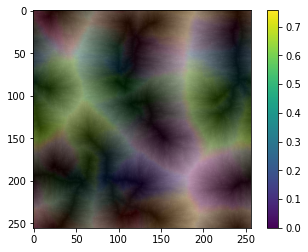

In [27]:
plt.imshow(automaton.old_cost.cpu().detach().numpy()/200.0)
plt.colorbar()

In [32]:
torch.max(automaton.field)

tensor(62.0255, device='cuda:0')